In [6]:
# Testing post-selected local Wannier measurements 

In [7]:
import numpy as np
import numpy.linalg as nla
import numpy.random as random
import scipy.linalg as la
import scipy.sparse as sp
from matplotlib import pyplot as plt
from itertools import product
import time
from tqdm import tqdm
from IPython.display import clear_output
from numpy import fft
import math

In [8]:
'''
    Wannier Projectors
'''

def flat_projectors_uniform_CI(Nx, Ny, alpha, nshell=None):
    Nx = int(Nx); Ny = int(Ny); alpha = float(alpha)

    kx = 2*np.pi * np.fft.fftfreq(Nx, d=1.0)
    ky = 2*np.pi * np.fft.fftfreq(Ny, d=1.0)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')

    nx = np.sin(KX); ny = np.sin(KY); nz = alpha - np.cos(KX) - np.cos(KY)
    nmag = np.sqrt(nx*nx + ny*ny + nz*nz)
    nmag = np.where(nmag == 0, 1e-15, nmag)

    sx = np.array([[0,1],[1,0]], dtype=complex)
    sy = np.array([[0,-1j],[1j,0]], dtype=complex)
    sz = np.array([[1,0],[0,-1]], dtype=complex)
    I2 = np.eye(2, dtype=complex)

    hk = (nx[...,None,None]*sx + ny[...,None,None]*sy + nz[...,None,None]*sz) / nmag[...,None,None]
    Pminus_k = 0.5*(I2 - hk)
    Pplus_k  = 0.5*(I2 + hk)

    Rx = np.arange(Nx); Ry = np.arange(Ny)
    phase = (np.exp(1j*KX[...,None,None]*Rx[None,None,:,None]) *
             np.exp(1j*KY[...,None,None]*Ry[None,None,None,:]))             # (Nx,Ny,Rx,Ry)

    def k2_to_r2(Ak): return np.fft.fft2(Ak, axes=(0,1))

    tauA = (1/np.sqrt(2))*np.array([[1],[ 1]], dtype=complex)
    tauB = (1/np.sqrt(2))*np.array([[1],[-1]], dtype=complex)

    def make_W(Pk, tau):
        tau_dag = tau[:,0].conj()
        psi_k   = np.einsum('m,ijmn->ijn', tau_dag, Pk)      # (Nx,Ny,2)
        W0 = k2_to_r2(phase * psi_k[:,:,0][...,None,None])   # (Nx,Ny,Rx,Ry)
        W1 = k2_to_r2(phase * psi_k[:,:,1][...,None,None])
        W  = np.moveaxis(np.stack([W0,W1], axis=-1), -1, 2)  # (Nx,Ny,2,Rx,Ry)

        if nshell is not None:
            x = np.arange(Nx)[:,None,None,None]
            y = np.arange(Ny)[None,:,None,None]
            Rxg = np.arange(Nx)[None,None,:,None]
            Ryg = np.arange(Ny)[None,None,None,:]
            dx = ((x - Rxg + Nx//2) % Nx) - Nx//2
            dy = ((y - Ryg + Ny//2) % Ny) - Ny//2
            mask = (np.abs(dx) <= nshell) & (np.abs(dy) <= nshell)       # (Nx,Ny,Rx,Ry)
            W *= mask[:, :, None, :, :]

        denom = np.sqrt(np.sum(np.abs(W)**2, axis=(0,1,2), keepdims=True)) + 1e-15
        return W/denom

    W_Ap = make_W(Pplus_k,  tauA)   # (Nx,Ny,2,Rx,Ry)
    W_Bp = make_W(Pplus_k,  tauB)
    W_Am = make_W(Pminus_k, tauA)
    W_Bm = make_W(Pminus_k, tauB)

    def flatten_centers(W):
        # W: (Nx, Ny, 2, Rx, Ry)
        # Move (μ, x, y) up front => (2, Nx, Ny, Rx, Ry)
        W_mu_xy = np.transpose(W, (2, 0, 1, 3, 4))
        # Flatten (μ, x, y) into D = 2*Nx*Ny, keeping (Rx, Ry)
        return W_mu_xy.reshape(2 * Nx * Ny, Rx.size, Ry.size, order='F')

    WF_Ap = flatten_centers(W_Ap)  # (2*Nx*Ny, Nx, Ny)?? → (2*Nx*Ny, Rx, Ry)
    WF_Bp = flatten_centers(W_Bp)
    WF_Am = flatten_centers(W_Am)
    WF_Bm = flatten_centers(W_Bm)

    # Projectors per center: χ χ†  → (D,D,Rx,Ry)
    def projectors(WF):   # WF: (D, Rx, Ry)
        return np.einsum('dxy, exy->dexy', WF, WF.conj(), optimize=True)

    P_A_plus  = projectors(WF_Ap)
    P_B_plus  = projectors(WF_Bp)
    P_A_minus = projectors(WF_Am)
    P_B_minus = projectors(WF_Bm)

    return {
        'P_A_plus':  P_A_plus,
        'P_B_plus':  P_B_plus,
        'P_A_minus': P_A_minus,
        'P_B_minus': P_B_minus,
        # optionally also return the flattened χ’s if you want to inspect them:
        # 'Wflat_A_plus':  WF_Ap, 'Wflat_B_plus': WF_Bp,
        # 'Wflat_A_minus': WF_Am, 'Wflat_B_minus': WF_Bm,
    }

In [9]:
'''
    Complex covariance constructor  
'''
def random_unitary(N, rng=None):
    """
    Generate a random unitary U = exp(i H),
    where H is Hermitian from a Gaussian matrix M.
    """
    if rng is None:
        rng = np.random.default_rng()
    M = rng.standard_normal((N, N)) + 1j * rng.standard_normal((N, N))
    H = 0.5 * (M + M.conj().T)

    # Diagonalize H and exponentiate eigenvalues
    w, V = np.linalg.eigh(H)      # H = V diag(w) V^†
    U = V @ np.diag(np.exp(1j * w)) @ V.conj().T
    return U

def random_complex_fermion_covariance(Nx, Ny, rng=None):
    """
    Build G = U^† D U, where D = diag(1,...,1,-1,...,-1) with half +1 and half -1.
    Dimension is 2*Nx*Ny x 2*Nx*Ny.
    """
    N = 2 * Nx * Ny
    assert N % 2 == 0, "Total dimension 2*Nx*Ny must be even."
    if rng is None:
        rng = np.random.default_rng()

    diag = np.concatenate([np.ones(N//2), -np.ones(N//2)])
    D = np.diag(diag).astype(np.complex128)

    U = random_unitary(N, rng=rng)
    G = U.conj().T @ D @ U
    return G

In [10]:

def apply_measurement_covariance(G, P, Nx, Ny, occupied=True, rcond=1e-12, symmetrize=True):
    """
    Apply a measurement update G' = H22 - H21 @ inv(H11 - inv(G)) @ H12
    using an EPR-state via the Choi isomorphism.

    Inputs
    ------
    G : (2*Nx*Ny, 2*Nx*Ny) complex ndarray
        Complex fermion covariance (Hermitian).
    P : (2*Nx*Ny, 2*Nx*Ny) complex ndarray
        Projector (Hermitian, idempotent: P^2 = P). Specifies the measured subspace.
    Nx, Ny : ints
        Lattice dimensions; total Hilbert-space dim is 2*Nx*Ny.
    occupied : bool
        If True, measure P (occupied). If False, measure (I - P) i.e. "unoccupied".
    rcond : float
        Tikhonov regularization magnitude used only if (H11 - inv(G)) is near singular.
    symmetrize : bool
        If True, return (G' + G'^†)/2 to clean up numerical noise.

    Returns
    -------
    G_prime : (2*Nx*Ny, 2*Nx*Ny) complex ndarray
        Updated covariance.
    """
    Ntot = 2 * Nx * Ny

    G = np.asarray(G)
    P = np.asarray(P)
    if G.shape != (Ntot, Ntot) or P.shape != (Ntot, Ntot):
        raise ValueError(f"G and P must have shape {(Ntot, Ntot)}, "
                         f"got {G.shape} and {P.shape}")

    I = np.eye(Ntot, dtype=G.dtype)

    # Build H blocks
    if occupied:
        # H = [[-P, I-P], [I-P, P]]
        H11 = -P
        H12 = I - P
        H21 = I - P
        H22 = P
    else:
        # Unoccupied: H = [[P, I-P], [I-P, -P]]
        H11 = P
        H12 = I - P
        H21 = I - P
        H22 = -P

    # inv(G) via solve
    invG = np.linalg.solve(G, I)

    # A = H11 - inv(G)
    A = H11 - invG

    # Regularize if ill-conditioned
    s = np.linalg.svd(A, compute_uv=False)
    if s.min() < rcond * s.max():
        A = A + (rcond * s.max()) * I

    # Schur complement term: H21 @ inv(A) @ H12
    X = np.linalg.solve(A, H12)
    term = H21 @ X

    G_prime = H22 - term

    if symmetrize:
        G_prime = 0.5 * (G_prime + G_prime.conj().T)

    return G_prime

In [27]:

def apply_measurement_covariance_v2(G, P, Nx, Ny, occupied=True, rcond=1e-12, symmetrize=True):
    """
    Apply a measurement update G' = H22 - H21 @ inv(H11 - inv(G)) @ H12
    using an EPR-state via the Choi isomorphism.

    Inputs
    ------
    G : (4*Nx*Ny, 4*Nx*Ny) complex ndarray
        Complex fermion covariance (Hermitian).
    P : (2*Nx*Ny, 2*Nx*Ny) complex ndarray
        Projector (Hermitian, idempotent: P^2 = P). Specifies the measured subspace.
    Nx, Ny : ints
        Lattice dimensions; total Hilbert-space dim is 2*Nx*Ny.
    occupied : bool
        If True, measure P (occupied). If False, measure (I - P) i.e. "unoccupied".
    rcond : float
        Tikhonov regularization magnitude used only if (H11 - inv(G)) is near singular.
    symmetrize : bool
        If True, return (G' + G'^†)/2 to clean up numerical noise.

    Returns
    -------
    G_prime : (2*Nx*Ny, 2*Nx*Ny) complex ndarray
        Updated covariance.
    """

    def _solve_regularized(K, B, eps=1e-9):
        """
        Robustly solve K X = B. Try a direct solve; if singular/ill-conditioned,
        add a small diagonal Tikhonov term; finally fall back to a pseudoinverse.
        """
        try:
            return np.linalg.solve(K, B)
        except np.linalg.LinAlgError:
            pass
        n = K.shape[0]
        K_reg = K + eps * np.eye(n, dtype=K.dtype)
        try:
            return np.linalg.solve(K_reg, B)
        except np.linalg.LinAlgError:
            return np.linalg.pinv(K_reg) @ B


    def _block_diag2(A, B):
        """
        Minimal block_diag(A,B) without scipy.
        """
        n, m = A.shape[0], B.shape[0]
        Z1 = np.zeros((n, m), dtype=A.dtype)
        Z2 = np.zeros((m, n), dtype=B.dtype)
        return np.block([[A, Z1],
                         [Z2, B]])
    
    Ntot = 4 * Nx * Ny
    Nlayer = Ntot//2

    Ilayer = np.eye(Nlayer, dtype=complex)
    Gtt = G[0:Nlayer,   0:Nlayer]
    Gbb = G[Nlayer:,    Nlayer:]
    Gbt = G[Nlayer:,    0:Nlayer]
    # Build H blocks
    if occupied:
        # occupied: H = [[-P, I-P], [I-P, P]]
        H11 = -P
        H21 = Ilayer - P
        H22 = P
    else:
        # unoccupied: H = [[P, I-P], [I-P, -P]]
        H11 =  P
        H21 = Ilayer - P
        H22 = -P
    # K X = L^†
    K = np.block([[H11,    -Ilayer],
                  [-Ilayer,  Gtt   ]])
    L = _block_diag2(H21, Gbt)
    invK_Ldag = _solve_regularized(K, L.conj().T, eps=1e-9)
    M = _block_diag2(H22, Gbb)
    G_prime = M - L @ invK_Ldag
    if symmetrize:
        G_prime = 0.5 * (G_prime + G_prime.conj().T)
    return G_prime

In [12]:
def sector_masks(Nx, Ny, R=None, xref=None, yref=None):
    if R is None:
        R = 0.4 * min(Nx, Ny)
    if xref is None: xref = Nx // 2
    if yref is None: yref = Ny // 2

    inside = np.zeros((Nx, Ny), dtype=bool)
    A = np.zeros_like(inside)
    B = np.zeros_like(inside)
    C = np.zeros_like(inside)
    rr = R * R
    ymax = int(math.floor(R))
    a2 = 2*np.pi/3
    a4 = 4*np.pi/3

    for dy in range(-ymax, ymax + 1):
        y = yref + dy
        if y < 0 or y >= Ny:
            continue
        max_dx = int(math.floor(math.sqrt(rr - dy*dy)))
        x0 = max(0, xref - max_dx)
        x1 = min(Nx - 1, xref + max_dx)
        if x0 > x1:
            continue

        inside[x0:x1+1, y] = True
        dxs = np.arange(x0, x1+1) - xref
        dys = np.full_like(dxs, dy)
        theta = np.mod(np.arctan2(dys, dxs), 2*np.pi)

        A[x0:x1+1, y] = (theta >= 0)   & (theta < a2)
        B[x0:x1+1, y] = (theta >= a2)  & (theta < a4)
        C[x0:x1+1, y] = (theta >= a4)  & (theta < 2*np.pi)

    return A, B, C, inside

def _sector_indices_from_mask(mask, Nx, Ny):
    """
    Flatten (μ, x, y) with i = μ + 2*x + 2*Nx*y (μ=0,1).
    Returns indices for both orbitals at each (x,y) where mask[x,y] is True.
    """
    mask = np.asarray(mask, dtype=bool)
    xs, ys = np.nonzero(mask)
    idx0 = 0 + 2*xs + 2*Nx*ys
    idx1 = 1 + 2*xs + 2*Nx*ys
    return np.sort(np.concatenate([idx0, idx1]))

def chern_from_covariance_flat(G_flat, Nx, Ny, A_mask=None, B_mask=None, C_mask=None):
    """
    Compute the real-space Chern number from a flattened complex covariance.

    Steps:
      1) G2 = (G_flat + I)/2  with G_flat shape (2*Nx*Ny, 2*Nx*Ny)
      2) Reshape to (2, Nx, Ny, 2, Nx, Ny) using Fortran order (μ, x, y | ν, x', y')
      3) Build projector P = conj(G2) and flatten back consistently
      4) Return 12π i [ Tr(P_CA P_AB P_BC) - Tr(P_AC P_CB P_BA) ]
    """
    Ntot = 2 * Nx * Ny
    G_flat = np.asarray(G_flat, dtype=complex)
    if G_flat.shape != (Ntot, Ntot):
        raise ValueError(f"G_flat must have shape {(Ntot, Ntot)}, got {G_flat.shape}")

    # Default masks if none provided
    if (A_mask is None) or (B_mask is None) or (C_mask is None):
        A_mask, B_mask, C_mask, _ = sector_masks(Nx, Ny)

    # 1) Two-point function
    I = np.eye(Ntot, dtype=complex)
    G2 = 0.5 * (G_flat + I)

    # 3) Projector P = conj(G2_6), then flatten back to (Ntot, Ntot) consistently
    P = G2.conj()

    # Sector indices (both orbitals per selected site)
    iA = _sector_indices_from_mask(A_mask, Nx, Ny)
    iB = _sector_indices_from_mask(B_mask, Nx, Ny)
    iC = _sector_indices_from_mask(C_mask, Nx, Ny)

    # Blocks
    P_CA = P[np.ix_(iC, iA)]
    P_AB = P[np.ix_(iA, iB)]
    P_BC = P[np.ix_(iB, iC)]

    P_AC = P[np.ix_(iA, iC)]
    P_CB = P[np.ix_(iC, iB)]
    P_BA = P[np.ix_(iB, iA)]

    # Chern
    t1 = np.trace(P_CA @ P_AB @ P_BC)
    t2 = np.trace(P_AC @ P_CB @ P_BA)
    return 12 * np.pi * 1j * (t1 - t2)

In [28]:
def chern_sweep_wannier_measurements(Nx, Ny, alpha, G0 = None,  cycles=5, A_mask=None, B_mask=None, C_mask=None,
                                     nshell=None, rng=None,
                                     rcond=1e-12, symmetrize=True,
                                     tol=1e-8):
    """
    For each center (Rx, Ry):
      - occupied(A_minus), occupied(B_minus), unoccupied(A_plus), unoccupied(B_plus)
      - compute real-space Chern number and append to list
      - check if G^2 ≈ I and append 1 if true, else 0

    Returns
    -------
    cherns : (Nx*Ny,) ndarray of complex
        Real-space Chern number per center
    g2_flags : (Nx*Ny,) ndarray of int
        1 if G^2 ≈ I at that step, else 0
    """
    D = 4 * Nx * Ny
    I = np.eye(D, dtype=complex)

    # 1) random initial covariance
    if G0 is None:
        G = random_complex_fermion_covariance(Nx, Ny, rng=rng)
    else:
        U = random_unitary(D)
        G = U.conj().T @ G0 @ U

    # 2) Wannier projectors dict
    Pdict = flat_projectors_uniform_CI(Nx, Ny, alpha, nshell=nshell)

    cherns = []
    g2_flags = []

    for idx in range(cycles):
        for rx in range(Nx):
            for ry in range(Ny):
                # Extract center projectors
                P_Am = Pdict['P_A_minus'][:, :, rx, ry]
                P_Bm = Pdict['P_B_minus'][:, :, rx, ry]
                P_Ap = Pdict['P_A_plus'] [:, :, rx, ry]
                P_Bp = Pdict['P_B_plus'] [:, :, rx, ry]
    
                # 3) Measurements in the required order
                G = apply_measurement_covariance_v2(G, P_Am, Nx, Ny, occupied=True,
                                                 rcond=rcond, symmetrize=symmetrize)
                G = apply_measurement_covariance_v2(G, P_Bm, Nx, Ny, occupied=True,
                                                 rcond=rcond, symmetrize=symmetrize)
                G = apply_measurement_covariance_v2(G, P_Ap, Nx, Ny, occupied=False,
                                                 rcond=rcond, symmetrize=symmetrize)
                G = apply_measurement_covariance_v2(G, P_Bp, Nx, Ny, occupied=False,
                                                 rcond=rcond, symmetrize=symmetrize)
    
                # 5) Check G^2 ≈ I
                if np.allclose(G @ G, I, atol=tol):
                    g2_flags.append(1)
                else:
                    g2_flags.append(0)
        
        # 4) Chern after this center
        #ch = chern_from_covariance_flat(G, Nx, Ny, A_mask, B_mask, C_mask)
        #cherns.append(ch)

    return G #, np.asarray(cherns).reshape(cycles), np.asarray(g2_flags).reshape(Nx*Ny*cycles)

In [20]:
# ----------------------------------------------------
# Construct single-particle real-space projector
# ----------------------------------------------------

# Parameters
Nx = 8
Ny = Nx
alpha = 1

# --- k-grids in FFT's native ordering (radians per site) ---
kx = 2*np.pi * np.fft.fftfreq(Nx, d=1.0)            # (Nx,)
ky = 2*np.pi * np.fft.fftfreq(Ny, d=1.0)            # (Ny,)
KX, KY = np.meshgrid(kx, ky, indexing='ij')         # (Nx, Ny)

# --- Hamiltonian vector n(k) ---
nx = np.sin(KX)
ny = np.sin(KY)
nz = alpha - np.cos(KX) - np.cos(KY)
n_mag = np.sqrt(nx**2 + ny**2 + nz**2)
n_mag = np.where(n_mag == 0, 1e-15, n_mag)          # avoid divide-by-zero


# FFT from n(k) k-space to real space
def k_to_r_rel(nk, k_is_centered=False, norm='backward'):
    """
    nk: (Nx, Ny) array holding n(kx,ky) on the FFT grid.
    k_is_centered: True if nk is fftshifted so k=0 is at the center.
    norm: 'backward' (ifft divides by Nx*Ny), 'ortho', or 'forward'.
    Returns:
        N : (Nx, Ny, Nx, Ny) with N[x,y,xp,yp] = n((x-xp) mod Nx, (y-yp) mod Ny)
        nR: (Nx, Ny) inverse FFT kernel n(Rx,Ry)
    """
    Nx, Ny = nk.shape
    if k_is_centered:
        nk = np.fft.ifftshift(nk)
    nR = np.fft.ifft2(nk, norm=norm)
    nR = np.real_if_close(nR, tol=1e3)

    x = np.arange(Nx)
    y = np.arange(Ny)
    X  = x[:, None, None, None]      # (Nx,1,1,1)
    Xp = x[None, None, :, None]      # (1,1,Nx,1)
    Y  = y[None, :, None, None]      # (1,Ny,1,1)
    Yp = y[None, None, None, :]      # (1,1,1,Ny)

    dX = (X - Xp) % Nx               # (Nx,1,Nx,1)
    dY = (Y - Yp) % Ny               # (1,Ny,1,Ny)

    N = nR[dX, dY]                   # broadcasts to (Nx,Ny,Nx,Ny)
    return N


# real space n(r,r')
nx_real = k_to_r_rel(nx/n_mag)
ny_real = k_to_r_rel(ny/n_mag)
nz_real = k_to_r_rel(nz/n_mag)

# Paulis
pauli_x = np.array([[0,1],[1,0]], dtype=complex)
pauli_y = 1j*np.array([[0,-1],[1,0]], dtype=complex)
pauli_z = np.array([[1,0],[0,-1]], dtype=complex)

# real space h(r,r')_{\sigma\eta}
h_real = np.moveaxis(nx_real[..., None, None] * pauli_x + ny_real[..., None, None] * pauli_y + nz_real[..., None, None] * pauli_z, 4, 2)

# Single-particle projector to lower-band
dims = (Nx, Ny, 2)
I = np.eye(np.prod(dims)).reshape(*dims, *dims)
Pminus = (1/2)*(I - h_real)
print(np.shape(Pminus))


(8, 8, 2, 8, 8, 2)


In [29]:
Nlayer = 2*Nx*Ny
diag = np.concatenate([np.ones(Nlayer//2), -np.ones(Nlayer//2), np.ones(Nlayer)])
G0 = np.diag(diag).astype(np.complex128)
G = chern_sweep_wannier_measurements(Nx, Ny, G0 = G0, alpha=1.0, cycles=10)

In [25]:
def flatten_covariance(G6, Nx, Ny):
    """
    Flatten (Nx, Ny, 2, Nx, Ny, 2) -> (2*Nx*Ny, 2*Nx*Ny)
    with index i = mu + 2*x + 2*Nx*y.
    """
    # reorder to group (mu,x,y) for rows and (nu,x',y') for cols
    G_perm = np.transpose(G6, (2,0,1, 5,3,4))   # (mu,x,y, nu,x',y')

    # reshape with Fortran order so mu fastest, then x, then y
    Ntot = 2 * Nx * Ny
    
    G_flat = G_perm.reshape(Ntot, Ntot, order='F')
    return G_flat

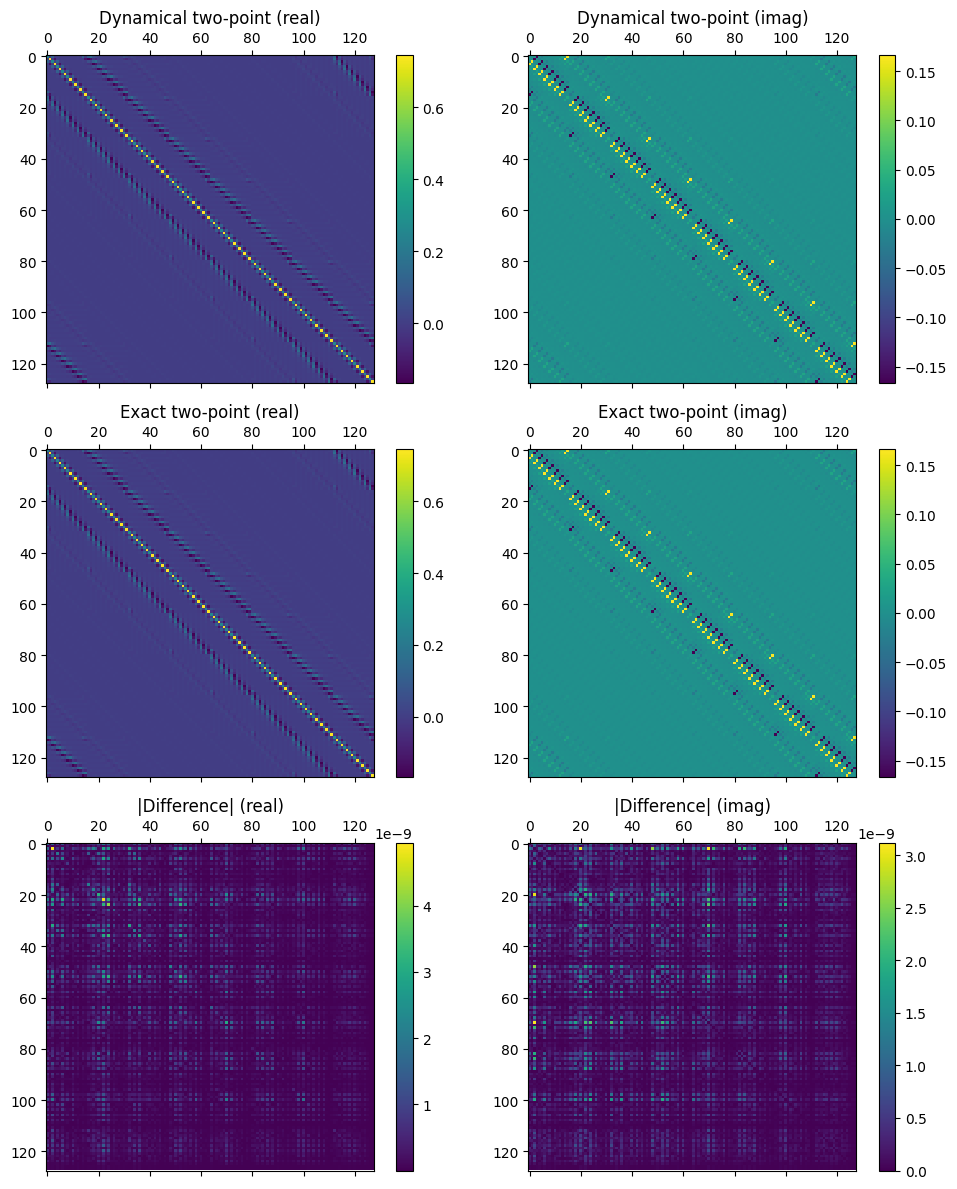

In [30]:
Nlayer = 2*Nx*Ny
Ilayer = np.eye(Nlayer)
Gtt = G[:Nlayer,:Nlayer]
G2_dyn = 0.5 * (Gtt + Ilayer)
G2_exact = flatten_covariance(Pminus.conj(), Nx, Ny)

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Row 1: Dynamical two-point
im0 = axes[0, 0].matshow(G2_dyn.real)
axes[0, 0].set_title("Dynamical two-point (real)")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].matshow(G2_dyn.imag)
axes[0, 1].set_title("Dynamical two-point (imag)")
fig.colorbar(im1, ax=axes[0, 1])

# Row 2: Exact two-point
im2 = axes[1, 0].matshow(G2_exact.real)
axes[1, 0].set_title("Exact two-point (real)")
fig.colorbar(im2, ax=axes[1, 0])

im3 = axes[1, 1].matshow(G2_exact.imag)
axes[1, 1].set_title("Exact two-point (imag)")
fig.colorbar(im3, ax=axes[1, 1])

# Row 3: Absolute differences
im4 = axes[2, 0].matshow(np.abs(G2_dyn.real - G2_exact.real))
axes[2, 0].set_title("|Difference| (real)")
fig.colorbar(im4, ax=axes[2, 0])

im5 = axes[2, 1].matshow(np.abs(G2_dyn.imag - G2_exact.imag))
axes[2, 1].set_title("|Difference| (imag)")
fig.colorbar(im5, ax=axes[2, 1])

plt.tight_layout()
plt.show()

In [47]:


def plot_chern_sweep(Nx, Ny, alpha, cycles = 5, A_mask=None, B_mask=None, C_mask=None,
                     nshell=None, rng=None, rcond=1e-12, symmetrize=True):
    """
    Run the Wannier measurement sweep and plot the Chern number vs list index.

    Returns
    -------
    fig, ax, cherns, g2_flags : (Figure, Axes, np.ndarray, np.ndarray)
        Plot figure/axes, Chern values (length Nx*Ny), and 0/1 flags for G^2≈I.
    """
    # Use provided masks or build defaults
    if A_mask is None or B_mask is None or C_mask is None:
        A_mask, B_mask, C_mask, _ = sector_masks(Nx, Ny)

    _, cherns, g2_flags = chern_sweep_wannier_measurements(
        Nx, Ny, alpha, cycles, A_mask, B_mask, C_mask,
        nshell=nshell, rng=rng, rcond=rcond, symmetrize=symmetrize
    )

    # Plot (show real part; imaginary drift should be ~0 up to FP noise)
    fig, ax = plt.subplots()
    x = np.arange(cherns.size)
    ax.plot(np.real(cherns), label="Re Chern", marker = 'o')

    # Highlight where G^2 != I
    bad = (g2_flags == 0)
    if np.any(bad):
        ax.plot(x[bad], np.real(cherns)[bad], 'o', ms=4, label="G^2≉I (flag=0)")

    ax.set_ylabel("Real-space Chern (Re)")
    ax.set_title(f"Chern vs Center Index — Nx={Nx}, Ny={Ny}, α={alpha}")
    ax.legend(loc="best")

    # Optional: quick sanity print for imag part magnitude
    im_max = np.max(np.abs(np.imag(cherns)))
    if im_max > 1e-8:
        print(f"[warn] max |Im(Chern)| = {im_max:.2e} (numerical noise expected)")

    return fig, ax, cherns, g2_flags

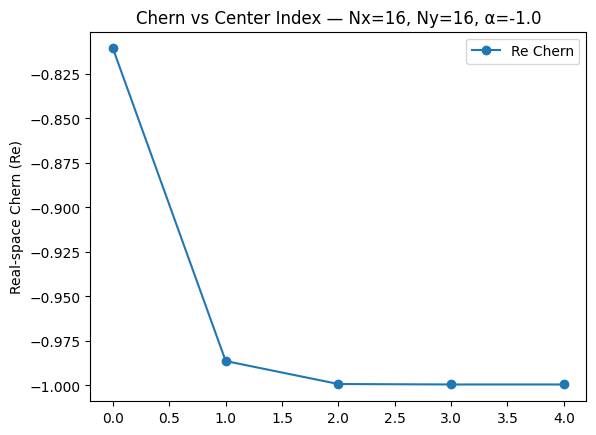

In [ ]:
fig, ax, chs, g2_flags = plot_chern_sweep(16, 16, alpha=1.0, cycles=5, nshell=None, rng=np.random.default_rng(0))
plt.show()

In [34]:
print(g2_flags)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
